In [1]:
pip install tqdm

Note: you may need to restart the kernel to use updated packages.


In [2]:
import torchvision
import torch
import torch.optim as optim
import numpy as np
import torch.nn as nn
from tqdm.autonotebook import tqdm, trange
from matplotlib import pyplot as plt
from torchvision.datasets import ImageFolder
from torchvision import transforms, models
from torch.utils.data import random_split, Dataset, DataLoader
from collections import Counter
from torch.optim import lr_scheduler

/tmp/ipykernel_23/994840999.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [3]:
# Open the file with labels and save it for futher using
labels_file = open('/kaggle/input/food41/meta/meta/labels.txt', 'r') # Labels and images from https://www.kaggle.com/datasets/kmader/food41
labels = list(map(lambda line: line.rstrip(), labels_file.readlines()))
number_of_classes = len(labels)
print('Number of classes in train: {}'.format(number_of_classes))

Number of classes in train: 101


In [4]:
# Normalize using std and mean ImageNet, because I will use pretrained on Imagenet EfficientNet  
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
# Core transforms for any images
base_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])
# Augmentations for train dataset, because this makes it more robust and generalizes better
train_transforms = transforms.Compose([
    transforms.RandomChoice([
        transforms.Compose([
            transforms.Resize(size=300, max_size=301),
            transforms.CenterCrop(300),
            transforms.RandomCrop(250)
        ]),
        transforms.RandomRotation(degrees=(-25, 25)),
        transforms.RandomHorizontalFlip(p=1)
    ]),
    base_transforms
])

In [5]:
# Create train and val datasets
root = '/kaggle/input/food41/images' # Labels and images from https://www.kaggle.com/datasets/kmader/food41
dataset = ImageFolder(root=root)
split_coef_for_test = 0.25
number_of_samples = len(dataset)
split = int(number_of_samples * split_coef_for_test)
train, val = random_split(dataset, [number_of_samples - split, split])
train.dataset.transform = train_transforms
val.dataset.transform = base_transforms
print('Number of samples in train: {}'.format(len(train)))
print('Number of samples in test: {}'.format(len(val)))     

Number of samples in train: 75750
Number of samples in test: 25250


In [6]:
# Create train and val dataloaders
batch_size = 8
num_workers = 2
train_dataloader = DataLoader(dataset=train, batch_size=batch_size,
                              shuffle=True, num_workers=num_workers)
val_dataloader = DataLoader(dataset=val, batch_size=batch_size,
                            num_workers=num_workers)

In [7]:
def show_image(image, label, plot, mean, std):
    image = np.array(image).transpose((1, 2, 0))
    image = std * image + mean
    if label is not None:
        plot.set_title(label)
    plot.imshow(image)

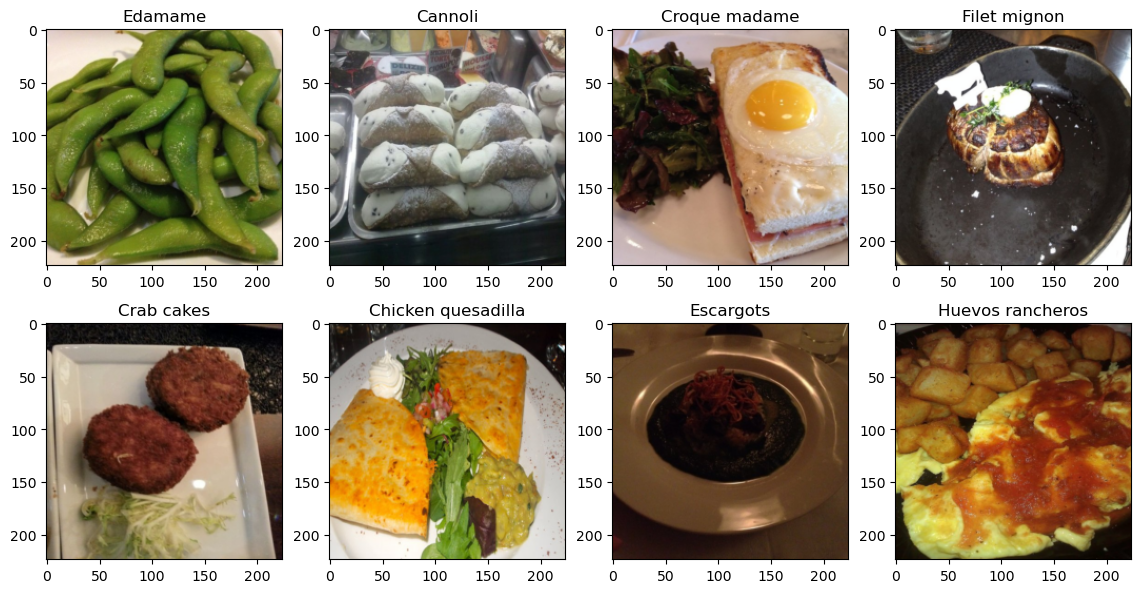

In [8]:
# Showing how looks the dataset
images, label_indxs = next(iter(val_dataloader))
_, axs = plt.subplots(2, 4, figsize=(14, 7))
for image, label, ax in zip(images, label_indxs.tolist(), axs.flatten()):
    name = labels[label]
    show_image(image, name, ax, mean, std)

In [9]:
def train(model, dataloaders, device, phases, scheduler, optimizer, criterion, max_epochs=25):
    best_model_wts = model.state_dict()
    best_acc = .0
    losses = {
        'train': [],
        'val': []
    }
    data_sizes = {x: len(dataloaders[x].dataset) for x in phases}
    model.to(device)
    pbar = trange(max_epochs)
    for epoch in pbar:
        for phase in phases:
            running_loss = .0
            running_acc = .0
            if phase == 'train':
                scheduler.step()
                model.train()
            else:
                model.eval()
            for data in tqdm(dataloaders[phase]):
                image, label = data
                image = image.to(device)
                label = label.to(device)
                if phase == 'train':
                    optimizer.zero_grad()
                    output = model(image)
                else:
                    with torch.no_grad():
                        output = model(image)
                loss = criterion(output, label)
                prediction = torch.argmax(output, dim=1)
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                running_loss += loss.item()
                running_acc += int(torch.sum(prediction == label.data))
            epoch_loss = running_loss / data_sizes[phase]
            epoch_acc = running_acc / data_sizes[phase]
            losses[phase].append(epoch_loss)
            pbar.set_description(desc='{} phase: loss={:.4f}, acc={:.4f}'.format(phase, epoch_loss, epoch_acc))
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
    print('Best test accuracy: {:4f}'.format(best_acc))
    model.load_state_dict(best_model_wts)

In [10]:
model = models.efficientnet_b7(pretrained=True)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B7_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B7_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b7_lukemelas-dcc49843.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b7_lukemelas-dcc49843.pth
100%|██████████| 255M/255M [00:01<00:00, 162MB/s]


In [11]:
unfreeze_num = 3
for param in model.features[:-unfreeze_num].parameters():
    param.requires_grad = False
model.classifier = nn.Linear(in_features=2560, out_features=number_of_classes, bias=True)
optimizer = optim.Adam(list(model.classifier.parameters())[-unfreeze_num:] +
                       list(model.features.parameters()), lr=3e-4)
criterion = nn.CrossEntropyLoss()
scheduler = lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.1)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
dataloaders = {
    'train': train_dataloader,
    'val': val_dataloader
}
phases = ['train', 'val']

In [12]:
train(model, dataloaders, device, phases, scheduler, optimizer, criterion, max_epochs=22)

  0%|          | 0/22 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


  0%|          | 0/9469 [00:00<?, ?it/s]

  0%|          | 0/3157 [00:00<?, ?it/s]

  0%|          | 0/9469 [00:00<?, ?it/s]

  0%|          | 0/3157 [00:00<?, ?it/s]

  0%|          | 0/9469 [00:00<?, ?it/s]

  0%|          | 0/3157 [00:00<?, ?it/s]

  0%|          | 0/9469 [00:00<?, ?it/s]

  0%|          | 0/3157 [00:00<?, ?it/s]

  0%|          | 0/9469 [00:00<?, ?it/s]

  0%|          | 0/3157 [00:00<?, ?it/s]

  0%|          | 0/9469 [00:00<?, ?it/s]

  0%|          | 0/3157 [00:00<?, ?it/s]

  0%|          | 0/9469 [00:00<?, ?it/s]

  0%|          | 0/3157 [00:00<?, ?it/s]

  0%|          | 0/9469 [00:00<?, ?it/s]

  0%|          | 0/3157 [00:00<?, ?it/s]

  0%|          | 0/9469 [00:00<?, ?it/s]

  0%|          | 0/3157 [00:00<?, ?it/s]

  0%|          | 0/9469 [00:00<?, ?it/s]

  0%|          | 0/3157 [00:00<?, ?it/s]

  0%|          | 0/9469 [00:00<?, ?it/s]

  0%|          | 0/3157 [00:00<?, ?it/s]

  0%|          | 0/9469 [00:00<?, ?it/s]

  0%|          | 0/3157 [00:00<?, ?it/s]

  0%|          | 0/9469 [00:00<?, ?it/s]

  0%|          | 0/3157 [00:00<?, ?it/s]

  0%|          | 0/9469 [00:00<?, ?it/s]

  0%|          | 0/3157 [00:00<?, ?it/s]

  0%|          | 0/9469 [00:00<?, ?it/s]

  0%|          | 0/3157 [00:00<?, ?it/s]

  0%|          | 0/9469 [00:00<?, ?it/s]

  0%|          | 0/3157 [00:00<?, ?it/s]

  0%|          | 0/9469 [00:00<?, ?it/s]

  0%|          | 0/3157 [00:00<?, ?it/s]

  0%|          | 0/9469 [00:00<?, ?it/s]

  0%|          | 0/3157 [00:00<?, ?it/s]

  0%|          | 0/9469 [00:00<?, ?it/s]

  0%|          | 0/3157 [00:00<?, ?it/s]

  0%|          | 0/9469 [00:00<?, ?it/s]

  0%|          | 0/3157 [00:00<?, ?it/s]

  0%|          | 0/9469 [00:00<?, ?it/s]

  0%|          | 0/3157 [00:00<?, ?it/s]

  0%|          | 0/9469 [00:00<?, ?it/s]

  0%|          | 0/3157 [00:00<?, ?it/s]

Best test accuracy: 0.756277


In [13]:
torch.save(model.state_dict(), f='efficientnet_b7')

In [15]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        
        #encoder
        self.pool = nn.MaxPool2d(2, stride=2, return_indices=True)
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        

        # decoder (upsampling)
        self.upsample = nn.MaxUnpool2d(2, stride=2)
        self.dec_conv0 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.dec_conv1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.dec_conv2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        self.dec_conv3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=32, out_channels=3, kernel_size=3, padding=1),
            nn.BatchNorm2d(3)
        )

    def forward(self, x):
        # encoder
        e0, ind0 = self.pool(self.enc_conv0(x))
        e1, ind1 = self.pool(self.enc_conv1(e0))
        e2, ind2 = self.pool(self.enc_conv2(e1))
        e3, ind3 = self.pool(self.enc_conv3(e2))

        # decoder
        d0 = self.upsample(e3, indices=ind3)
        d1 = self.upsample(self.dec_conv0(d0), indices=ind2)
        d2 = self.upsample(self.dec_conv1(d1), indices=ind1)
        d3 = self.upsample(self.dec_conv2(d2), indices=ind0)
        return self.dec_conv3(d3)

In [16]:
def train(autoencoder, dataloader, device, optimizer, criterion, max_epochs=25):
    pbar = trange(max_epochs)
    for epoch in pbar:
        running_loss = .0
        autoencoder.train()
        for data in tqdm(dataloader):
            image, _ = data
            image = image.to(device)
            optimizer.zero_grad()
            output = autoencoder(image)
            loss = criterion(output, image)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * image.size(0)
        epoch_loss = running_loss / len(dataloader)
        pbar.set_description(desc='train phase: loss={:.4f}'.format(epoch_loss))

In [17]:
autoencoder = Autoencoder()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)
criterion = nn.MSELoss()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
autoencoder.to(device)

Autoencoder(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc_conv0): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (enc_conv1): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (enc_conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (enc_conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (upsample): MaxUnpool2d(kernel_size=(2, 2), stride=(

In [18]:
general_dataset = TransformedDataset(dataset, base_transfroms)
general_dataloader = DataLoader(dataset=general_dataset, batch_size=batch_size,
                              shuffle=True, num_workers=num_workers)

NameError: name 'TransformedDataset' is not defined

In [ ]:
train(autoencoder, general_dataloader, device, optimizer, criterion, max_epochs=30)

In [ ]:
torch.save(autoencoder.state_dict(), f='efficientnet_b7')